## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [5]:
import os
import shutil
import glob

## Arguments & Initializations

In [6]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [7]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [8]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [9]:
DATASET = "german_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia2"

In [10]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

In [11]:
ATTACK

'mia2'

## Loading & Splitting Dataset

In [12]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [13]:
dataset_orig.features.shape

(1000, 57)

In [14]:
privileged_groups

[{'sex': 1}]

In [15]:
sens_attr

'sex'

In [16]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [17]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

## Run Mitigating Algorithms

### Setup for MIA2

In [18]:
seed = 1234
np.random.seed(seed)

In [19]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [20]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    if (X.shape[0] < 6000):
        num_train_points = int(X.shape[0] * 0.3)
        num_test_points = int(X.shape[0] * 0.3)
        num_population_points = int(X.shape[0] * 0.4)  
    else:
        num_train_points = int(X.shape[0] * 0.12)
        num_test_points = int(X.shape[0] * 0.12)
        num_population_points = int(X.shape[0] * 0.3)  
        
    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [21]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [22]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [23]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [24]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

        print("#### Train dataset's features are as below:")
#         print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )

        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )

        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
        return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [25]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    print('ITERATION ', i)
    dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
    
    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)

    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    
    while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
        print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
         # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)
        
    print("DIFFERENCE IS GOOD")
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
                
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

#     # cpp mitigator
#     cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

ITERATION  0
GET UNIQUE INDICES REFERENCE
Number of train points: 300
Number of test points: 300
Number of population points: 400
CREATE BINARY LABEL DATASET
CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  212.0 88.0
base_pos unpriv:  0.6022727272727273
base_pos priv:  0.7216981132075472
DIFFERENCE IS GOOD
base_pos unpriv:  0.6022727272727273
base_pos priv:  0.7216981132075472
no bias type specified
#### Training Dataset shape
(300, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


origin, transf:  300 337
after transf priv:  0.7216981132075472
after transf unpriv:  0.72
Difference in mean outcomes between unprivileged and privileged groups = -0.001698
[INFO]: training decision tree
RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['syn_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<defa

Unprivileged Positive Predictions (Favorable): 65
Privileged Positive Predictions (Favorable): 133
Unprivileged Negative Predictions: 38
Privileged Negative Predictions: 64
Unprivileged Positive Predictions (Favorable): 65
Privileged Positive Predictions (Favorable): 133
Unprivileged Negative Predictions: 38
Privileged Negative Predictions: 64
Unprivileged Positive Predictions (Favorable): 58
Privileged Positive Predictions (Favorable): 130
Unprivileged Negative Predictions: 45
Privileged Negative Predictions: 67
Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 103
Privileged Negative Predictions: 197
Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 103
Privileged Negative Predictions: 197
Best thresh:  [0.7472144]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 58
Privileged Po

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.005265       0.999982                         0.001755   
1    0.003366       0.999993                         0.000561   
2    0.009360       0.999946                         0.001560   
3    0.003318       0.999993                         0.000276   
4    0.012374       0.999921                         0.001178   
..        ...            ...                              ...   
295  0.015912       0.999830                         0.005304   
296  0.013616       0.999895                         0.001702   
297  0.023988       0.999512                         0.007996   
298  0.005799       0.999982                         0.000966   
299  0.003442       0.999990                         0.000574   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.001755           0.000439           0.000439  

[INFO]: training decision tree
RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0

Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 190
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 190
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 190
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 190
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 190
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 190
Unprivileged Negative Predictions: 8
Privilege

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 14
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 14
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 14
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 14
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 14
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.79      0.74      0.77  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

privileged vs. unprivileged:  200.0 100.0
base_pos unpriv:  0.57
base_pos priv:  0.72
DIFFERENCE IS GOOD
base_pos unpriv:  0.57
base_pos priv:  0.72
no bias type specified
#### Training Dataset shape
(300, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employm

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 99
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 99
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 99
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 99
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 99
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 99
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 2
Privilege

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.004367       0.999985                         0.000728   
1    0.009093       0.999957                         0.001010   
2    0.009266       0.999950                         0.002316   
3    0.004197       0.999988                         0.001399   
4    0.006339       0.999973                         0.002113   
..        ...            ...                              ...   
295  0.020507       0.999718                         0.006836   
296  0.004458       0.999980                         0.001486   
297  0.018401       0.999777                         0.006134   
298  0.005659       0.999983                         0.000236   
299  0.005227       0.999986                         0.000581   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.001456           0.000728           0.000728  1.0    0.000728   
1           0.000758          

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.76      0.66      0.71        99
         1.0       0.84      0.90      0.87       201

    accuracy                           0.82       300
   macro avg       0.80      0.78      0.79       300
weighted avg       0.82      0.82      0.82       300

Train accuracy:  0.82
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 95
Privileged Posit

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 5
Priv

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['un_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71        89
         1.0       0.88      0.88      0.88       211

    accuracy                           0.83       300
   macro avg       0.80      0.79      0.80       300
weighted avg       0.83      0.83      0.83       300

Train accuracy:  0.83
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 83
Privileged Positiv

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privilege

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.004690       0.999984                         0.002084   
1    0.015787       0.999850                         0.004210   
2    0.008988       0.999956                         0.001498   
3    0.003900       0.999991                         0.000650   
4    0.004908       0.999985                         0.000818   
..        ...            ...                              ...   
295  0.011479       0.999926                         0.001913   
296  0.014923       0.999853                         0.004974   
297  0.008081       0.999967                         0.000449   
298  0.014243       0.999883                         0.003798   
299  0.007778       0.999968                         0.001037   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.001563           0.000521           0.000521  1.0    0.000000   
1           0.003157          

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 88
Privileged Negative Predictions: 212
Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 88
Privileged Negative Predictions: 212
Best thresh:  [0.77318989]
Testing Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 42
Privileged Positive Predictions (Favorable): 104
Unprivileged Negative Predictions: 46
Privileged Negative Predictions: 108
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 300, Test = 300
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.15
  Positive predictive value: 0.57
  Optimal thershold: [0.35667494]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 34, Test = 21
  AUC: 0.62
  Privacy Risk: 0.61

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.81      0.61      0.69  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 68
Privileged Positive Predictions (Favorable): 178
Unprivileged Negative Predictions: 20
Privileged Negative Predictions: 34
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 300, Test = 300
  AUC: 0.57
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.15
  Positive predictive value: 0.57
  Optimal thershold: [0.02632575]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 34, Test = 21
  AUC: 0.68
  Privacy Risk: 0.64
  Accuracy: 0.71
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.30
  Positive predictive value: 1.00
  Optimal thershold: [0.05306536]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 55, Test = 67
  AUC: 0.50
  Privacy Risk: 0.58
  Accuracy: 0.57
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


origin, transf:  300 417
after transf priv:  0.6842105263157895
after transf unpriv:  0.6875
Difference in mean outcomes between unprivileged and privileged groups = 0.003289
[INFO]: training decision tree
RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['syn_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<def

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.001755       0.999998                         0.000390   
1    0.008116       0.999964                         0.001353   
2    0.003316       0.999994                         0.000170   
3    0.007166       0.999972                         0.001194   
4    0.003205       0.999987                         0.002137   
..        ...            ...                              ...   
295  0.007278       0.999971                         0.001617   
296  0.008224       0.999963                         0.001121   
297  0.003318       0.999993                         0.000276   
298  0.008510       0.999958                         0.001418   
299  0.019979       0.999790                         0.003330   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000780           0.000195           0.000390  

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 18
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 18
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 18
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 18
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 18
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 6
Priv

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.82      0.63      0.71  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 203
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 203
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 203
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 203
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 203
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 203
Unprivileged Negative Predictions: 3
Priv

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 82
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 82
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 82
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 82
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 82
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 82
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 5
Priv

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.005389       0.999979                         0.002395   
1    0.006420       0.999979                         0.000535   
2    0.002500       0.999997                         0.000083   
3    0.019074       0.999808                         0.002384   
4    0.019787       0.999797                         0.002199   
..        ...            ...                              ...   
295  0.005799       0.999982                         0.000966   
296  0.004320       0.999987                         0.001296   
297  0.008317       0.999944                         0.003697   
298  0.009665       0.999950                         0.001611   
299  0.007607       0.999969                         0.000761   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.001198           0.000599           0.000599  0.0    0.000000   
1           0.000134          

[INFO]: training decision tree
RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 6
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 6
Priv

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['un_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68        76
         1.0       0.89      0.90      0.89       224

    accuracy                           0.84       300
   macro avg       0.79      0.78      0.78       300
weighted avg       0.84      0.84      0.84       300

Train accuracy:  0.84
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Posit

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Pri

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.001656       0.999998                         0.000315   
1    0.008224       0.999963                         0.001121   
2    0.007589       0.999969                         0.001446   
3    0.004849       0.999988                         0.000162   
4    0.003888       0.999985                         0.002592   
..        ...            ...                              ...   
295  0.002793       0.999995                         0.000254   
296  0.003071       0.999995                         0.000384   
297  0.012078       0.999922                         0.001006   
298  0.009999       0.999934                         0.003333   
299  0.002567       0.999996                         0.000214   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000315           0.000079           0.000079  

INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.68      0.76      0.72        76
         1.0       0.92      0.88      0.90       224

    accuracy                           0.85       300
   macro avg       0.80      0.82      0.81       300
weighted avg       0.86      0.85      0.85       300

Train accuracy:  0.85
Validating Original ...
TEST
POS IND 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 197
Unprivileged Negative Predictions: 0
Pri

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.76      0.63      0.69  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['un_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['un_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.79      0.66      0.72        88
         1.0       0.87      0.93      0.90       212

    accuracy                           0.85       300
   macro avg       0.83      0.79      0.81       300
weighted avg       0.85      0.85      0.85       300

Train accuracy:  0.85
Validating Original ...
TEST
POS IND 1


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 74
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 18
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 74
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 18
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 74
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 18
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 74
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 18
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 74
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 18
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 74
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 1

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.004426       0.999990                         0.000123   
1    0.001706       0.999997                         0.000569   
2    0.007353       0.999964                         0.002451   
3    0.003430       0.999993                         0.000857   
4    0.004110       0.999990                         0.000685   
..        ...            ...                              ...   
295  0.007157       0.999971                         0.001193   
296  0.016335       0.999856                         0.002723   
297  0.006546       0.999978                         0.000436   
298  0.004833       0.999986                         0.000967   
299  0.005788       0.999983                         0.000193   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000246           0.000123           0.000123  

[INFO]: training decision tree
RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 201
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 201
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 201
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 201
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 201
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 201
Unprivileged Negative Predictions: 1
Privilege

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['un_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['un_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.71        90
         1.0       0.88      0.86      0.87       210

    accuracy                           0.82       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.82  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['syn_log_pop']
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.63      0.67        90
         1.0       0.88      0.91      0.89       256

    accuracy                           0.84       346
   macro avg       0.80      0.77      0.78       346
weighted avg       0.84      0.84      0.84       346

Train accuracy:  0.8410404624277457
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 93
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 92
Privi

Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 1
Privilege

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.006486       0.999977                         0.000721   
1    0.010423       0.999945                         0.000651   
2    0.015654       0.999869                         0.002609   
3    0.007016       0.999974                         0.001002   
4    0.006162       0.999981                         0.000342   
..        ...            ...                              ...   
395  0.001755       0.999998                         0.000390   
396  0.011885       0.999916                         0.003169   
397  0.023431       0.999704                         0.003905   
398  0.006015       0.999978                         0.002005   
399  0.006703       0.999977                         0.000559   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000721           0.000721           0.000360  1.0    0.000000  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 63
Privileged Positive Predictions (Favorable): 146
Unprivileged Negative Predictions: 30
Privileged Negative Predictions: 61
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 300, Test = 300
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.14
  Positive predictive value: 0.56
  Optimal thershold: [0.3254224]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 36, Test = 31
  AUC: 0.68
  Privacy Risk: 0.68
  Accuracy: 0.70
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.36
  Positive predictive value: 0.68
  Optimal thershold: [1.67182694]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 56, Test = 62
  AUC: 0.59
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.1

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.70      0.69      0.70  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['un_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['un_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.55      0.64        86
         1.0       0.84      0.93      0.88       214

    accuracy                           0.82       300
   macro avg       0.80      0.74      0.76       300
weighted avg       0.82      0.82      0.81       300

Train accuracy:  0.8233333333333334
Validating Original ...
T

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 1
Privilege

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.006151       0.999980                         0.000586   
1    0.007184       0.999973                         0.000342   
2    0.017515       0.999818                         0.002919   
3    0.005129       0.999986                         0.000641   
4    0.011764       0.999924                         0.001961   
..        ...            ...                              ...   
295  0.004367       0.999988                         0.000728   
296  0.004908       0.999985                         0.000818   
297  0.008356       0.999963                         0.001045   
298  0.011741       0.999924                         0.002609   
299  0.015736       0.999867                         0.002623   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000293           0.000586           0.000293  1.0    0.000293   
1           0.000342          

Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 196
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 8
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 196
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 8
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 196
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 8
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 196
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 8
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 196
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 8
Unprivileged Positive Predictions (Favorable): 95
Privileged Positive Predictions (Favorable): 196
Unprivileged Negative Predictions: 1
Privilege

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 204
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 204
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 204
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 204
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 190
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 14
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 190
Unprivileged Negative Predictions: 4
Privileg

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  207.0 93.0
base_pos unpriv:  0.6451612903225806
base_pos priv:  0.7004830917874396
DIFFERENCE IS GOOD
base_pos unpriv:  0.6451612903225806
base_pos priv:  0.7004830917874396
no bias type specified
#### Training Dataset shape
(300, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Priv

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.010105       0.999945                         0.001684   
1    0.015731       0.999874                         0.000983   
2    0.012263       0.999924                         0.001022   
3    0.011090       0.999918                         0.003697   
4    0.011833       0.999927                         0.000986   
..        ...            ...                              ...   
295  0.003092       0.999995                         0.000155   
296  0.005265       0.999982                         0.001755   
297  0.008658       0.999957                         0.001443   
298  0.020113       0.999786                         0.000838   
299  0.007843       0.999959                         0.003137   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000842           0.000842           0.000842  1.0    0.000000   
1           0.001311          

Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 13
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Priv

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 185
Unprivileged Negative Predictions: 0
Priv

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 11
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 11
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 11
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 11
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 11
Privileged Negative Predictions: 9
Unprivileged Positive Predictions (Favorable): 89
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 11
Pri

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 4
Privilege

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.015725       0.999850                         0.005242   
1    0.016970       0.999819                         0.005657   
2    0.019413       0.999751                         0.006471   
3    0.002973       0.999995                         0.000198   
4    0.003748       0.999993                         0.000156   
..        ...            ...                              ...   
295  0.010592       0.999943                         0.001009   
296  0.024383       0.999696                         0.002167   
297  0.004197       0.999991                         0.000200   
298  0.010030       0.999948                         0.000669   
299  0.017453       0.999819                         0.004987   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.001310           0.001310           0.001310  0.0    0.000000   
1           0.002828          

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74        95
         1.0       0.87      0.90      0.89       205

    accuracy                           0.84       300
   macro avg       0.82      0.80      0.81       300
weighted avg       0.84      0.84      0.84       300

Train accuracy:  0.84
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 100
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 98
Privileged Posit

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 184
Unprivileged Negative Predictions: 12
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 184
Unprivileged Negative Predictions: 12
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 184
Unprivileged Negative Predictions: 12
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 184
Unprivileged Negative Predictions: 12
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 184
Unprivileged Negative Predictions: 12
Privileged Negative Predictions: 16
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 184
Unprivileged Negative Predictions: 1

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.66      0.71  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

Unprivileged Positive Predictions (Favorable): 90
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 2
Unprivileged Positive Predictions (Favorable): 90
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 2
Unprivileged Positive Predictions (Favorable): 90
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 2
Unprivileged Positive Predictions (Favorable): 90
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 2
Unprivileged Positive Predictions (Favorable): 90
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 2
Unprivileged Positive Predictions (Favorable): 90
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 1
Privilege

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 209
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 209
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 209
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 209
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 209
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 209
Unprivileged Negative Predictions: 0
Privilege

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.005101       0.999986                         0.000378   
1    0.005779       0.999983                         0.000642   
2    0.012263       0.999924                         0.001022   
3    0.002965       0.999995                         0.000494   
4    0.006628       0.999977                         0.000552   
..        ...            ...                              ...   
295  0.005782       0.999982                         0.000482   
296  0.009093       0.999957                         0.001010   
297  0.015396       0.999866                         0.003421   
298  0.007856       0.999969                         0.000164   
299  0.004484       0.999981                         0.000747   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000756           0.000378           0.000189  1.0    0.000189   
1           0.000642          

Unprivileged Positive Predictions (Favorable): 86
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 86
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 86
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 86
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 86
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 86
Privileged Positive Predictions (Favorable): 198
Unprivileged Negative Predictions: 5
Priv

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 36
Privileged Positive Predictions (Favorable): 95
Unprivileged Negative Predictions: 55
Privileged Negative Predictions: 114
Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 91
Privileged Negative Predictions: 209
Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 91
Privileged Negative Predictions: 209
Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 91
Privileged Negative Predictions: 209
Best thresh:  [0.91629073]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 36
Privileged Positive Predictions (Favorable): 95
Unprivileged Negative Predictions: 55
Privileged Negative Predictions: 114
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

eg_log_pop deleted.
rew_log_pop deleted.
syn_log_pop deleted.
un_log_pop deleted.
ITERATION  12
GET UNIQUE INDICES REFERENCE
Number of train points: 300
Number of test points: 300
Number of population points: 400
CREATE BINARY LABEL DATASET
CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  217.0 83.0
base_pos unpriv:  0.6385542168674698
base_pos priv:  0.7327188940092166
DIFFERENCE IS GOOD
base_pos unpriv:  0.6385542168674698
base_pos priv:  0.7327188940092166
no bias type specified
#### Training Dataset shape
(300, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected groups
[{'sex': 1}] [{'sex': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30'

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72        88
         1.0       0.89      0.92      0.90       241

    accuracy                           0.86       329
   macro avg       0.82      0.80      0.81       329
weighted avg       0.85      0.86      0.85       329

Train accuracy:  0.8571428571428571
Validating Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 104
Privileged Positive Predictions (Favorable): 196
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 104
Privileged Positive Predictions (Favorable): 196
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 104
Privileged Positive Predictions (Favorable): 196
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 104
Privileged Positive

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.005331       0.999984                         0.000444   
1    0.012365       0.999910                         0.003297   
2    0.005329       0.999985                         0.000592   
3    0.003789       0.999992                         0.000758   
4    0.006412       0.999978                         0.000305   
..        ...            ...                              ...   
295  0.004619       0.999981                         0.000770   
296  0.005498       0.999982                         0.001466   
297  0.004550       0.999989                         0.000414   
298  0.000412       1.000000                         0.000069   
299  0.004849       0.999988                         0.000162   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000888           0.000444           0.000444  

[INFO]: training decision tree
RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 3
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 3
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 3
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 3
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 8
Privileged Negative Predictions: 3
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 8
Privilege

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.74      0.62      0.68  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Pred

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privilege

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.005626       0.999979                         0.001875   
1    0.003765       0.999993                         0.000314   
2    0.005181       0.999986                         0.000288   
3    0.005419       0.999985                         0.000226   
4    0.011391       0.999904                         0.005063   
..        ...            ...                              ...   
295  0.008776       0.999958                         0.001950   
296  0.009633       0.999934                         0.003853   
297  0.007242       0.999970                         0.001207   
298  0.008287       0.999965                         0.000691   
299  0.011538       0.999919                         0.003077   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.001875           0.000469           0.000469  0.0    0.000000   
1           0.000078          

Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privilege

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 79
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 9
Privileged Negative Predictions: 17
Unprivileged Positive Predictions (Favorable): 79
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 9
Privileged Negative Predictions: 17
Unprivileged Positive Predictions (Favorable): 79
Privileged Positive Predictions (Favorable): 187
Unprivileged Negative Predictions: 9
Privileged Negative Predictions: 25
Unprivileged Positive Predictions (Favorable): 79
Privileged Positive Predictions (Favorable): 187
Unprivileged Negative Predictions: 9
Privileged Negative Predictions: 25
Unprivileged Positive Predictions (Favorable): 79
Privileged Positive Predictions (Favorable): 187
Unprivileged Negative Predictions: 9
Privileged Negative Predictions: 25
Unprivileged Positive Predictions (Favorable): 71
Privileged Positive Predictions (Favorable): 177
Unprivileged Negative Predictions: 17
Pri

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

              precision    recall  f1-score   support

         0.0       0.75      0.64      0.69        77
         1.0       0.88      0.93      0.90       223

    accuracy                           0.85       300
   macro avg       0.82      0.78      0.80       300
weighted avg       0.85      0.85      0.85       300

Train accuracy:  0.8533333333333334
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predi

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privilege

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.016733       0.999807                         0.005578   
1    0.005236       0.999983                         0.001745   
2    0.023988       0.999512                         0.007996   
3    0.013952       0.999899                         0.001860   
4    0.005725       0.999980                         0.000954   
..        ...            ...                              ...   
295  0.010273       0.999933                         0.003424   
296  0.005723       0.999983                         0.000212   
297  0.006854       0.999968                         0.000762   
298  0.015721       0.999870                         0.002096   
299  0.006339       0.999973                         0.002113   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.005578           0.004183           0.001394  1.0    0.000000   
1           0.000873          

INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71        77
         1.0       0.89      0.91      0.90       223

    accuracy                           0.85       300
   macro avg       0.81      0.80      0.80       300
weighted avg       0.85      0.85      0.85       300

Train accuracy:  0.8533333333333334
Validating Original ...

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privilege

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.66      0.71  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.58      0.69        83
         1.0       0.86      0.96      0.90       217

    accuracy                           0.85       300
   macro avg       0.85      0.77      0.80       300
weighted avg       0.85      0.85      0.84       300

Train accuracy:  0.8533333333333334
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 206
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 90
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 90
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favora

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 2
Privileged Negative Predictions: 11
Unprivileged Positive Predictions (Favorable): 92
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 2
Priv

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.005584       0.999981                         0.001861   
1    0.002267       0.999995                         0.000756   
2    0.010126       0.999938                         0.002531   
3    0.011391       0.999904                         0.005063   
4    0.022980       0.999641                         0.007660   
..        ...            ...                              ...   
295  0.010387       0.999939                         0.002770   
296  0.018645       0.999811                         0.003107   
297  0.002793       0.999995                         0.000254   
298  0.004983       0.999977                         0.003322   
299  0.009022       0.999958                         0.000752   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000465           0.000465           0.000465  1.0    0.000465   
1           0.001133          

[INFO]: training decision tree
RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 6
Unprivileged Positive Predictions (Favorable): 91
Privileged Positive Predictions (Favorable): 200
Unprivileged Negative Predictions: 3
Privilege

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.57      0.68  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['un_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['un_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 5
Privileged Negative Predictions: 10
Unprivileged Positive Predictions (Favorable): 96
Privileged Positive Predictions (Favorable): 189
Unprivileged Negative Predictions: 5
Priv

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.005996       0.999975                         0.001332   
1    0.020357       0.999761                         0.004524   
2    0.007157       0.999971                         0.001193   
3    0.002885       0.999994                         0.000481   
4    0.009542       0.999954                         0.000636   
..        ...            ...                              ...   
295  0.009677       0.999941                         0.003226   
296  0.005714       0.999968                         0.003809   
297  0.011479       0.999926                         0.001913   
298  0.010596       0.999942                         0.001413   
299  0.003221       0.999994                         0.000644   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.001999           0.001332           0.000666  

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.84      0.58      0.69

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 199
Unprivileged Negative Predictions: 0
Pri

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

Unprivileged Positive Predictions (Favorable): 105
Privileged Positive Predictions (Favorable): 195
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 102
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 102
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 102
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 102
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 3
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 102
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 3
Pri

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 104
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 104
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 104
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 104
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 104
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 1
Privileged Negative Predictions: 7
Unprivileged Positive Predictions (Favorable): 104
Privileged Positive Predictions (Favorable): 188
Unprivileged Negative Predictions: 1
Pri

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.007944       0.999967                         0.000662   
1    0.004319       0.999990                         0.000360   
2    0.006446       0.999977                         0.000859   
3    0.008498       0.999955                         0.002833   
4    0.003135       0.999995                         0.000232   
..        ...            ...                              ...   
295  0.009493       0.999941                         0.003164   
296  0.008830       0.999958                         0.001104   
297  0.004689       0.999989                         0.000260   
298  0.009355       0.999951                         0.002079   
299  0.005861       0.999982                         0.000279   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000662           0.000331           0.000331  1.0    0.000331   
1           0.000480          

Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 4
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 4
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 4
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 4
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 4
Unprivileged Positive Predictions (Favorable): 101
Privileged Positive Predictions (Favorable): 191
Unprivileged Negative Predictions: 4
Pri

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 94
Privileged Positive Predictions (Favorable): 172
Unprivileged Negative Predictions: 11
Privileged Negative Predictions: 23
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 300, Test = 300
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.16
  Positive predictive value: 0.56
  Optimal thershold: [0.5389965]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 33, Test = 37
  AUC: 0.71
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.35
  Positive predictive value: 0.68
  Optimal thershold: [0.85195316]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 61, Test = 68
  AUC: 0.54
  Privacy Risk: 0.56
  Accuracy: 0.57
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.60
  Attacker advantage: 0.1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['un_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73        91
         1.0       0.89      0.86      0.87       209

    accuracy                           0.83       300
   macro avg       0.79      0.81      0.80       300
weighted avg       0.83      0.83      0.83       300

Train accuracy:  0.8266666666666667
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 107
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 104
Pr

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 

RUN DIRMITIGATOR
TRANSFROM PRIVACY METER DATASET
DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.013952       0.999899                         0.001860   
1    0.004983       0.999977                         0.003322   
2    0.019074       0.999808                         0.003179   
3    0.003269       0.999992                         0.001090   
4    0.015054       0.999854                         0.005018   
..        ...            ...                              ...   
295  0.009072       0.999953                         0.002016   
296  0.006632       0.999978                         0.000414   
297  0.016946       0.999826                         0.002824   
298  0.003328       0.999994                         0.000139   
299  0.008003       0.999964                         0.001779   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000930           0.000465           0.000465  

[INFO]: training decision tree
RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['dir_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['dir_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 12
Unprivileged Positive Predictions (Favorable): 103
Privileged Positive Predictions (Favorable): 181
Unprivileged Negative Predictions: 

Unprivileged Positive Predictions (Favorable): 69
Privileged Positive Predictions (Favorable): 123
Unprivileged Negative Predictions: 38
Privileged Negative Predictions: 70
Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 107
Privileged Negative Predictions: 193
Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 107
Privileged Negative Predictions: 193
Unprivileged Positive Predictions (Favorable): 0
Privileged Positive Predictions (Favorable): 0
Unprivileged Negative Predictions: 107
Privileged Negative Predictions: 193
Best thresh:  [0.69314718]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 69
Privileged Positive Predictions (Favorable): 123
Unprivileged Negative Predictions: 38
Privileged Negative Predictions: 70
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['un_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75        81
         1.0       0.90      0.92      0.91       219

    accuracy                           0.87       300
   macro avg       0.83      0.82      0.83       300
weighted avg       0.86      0.87      0.87       300

Train accuracy:  0.8666666666666667
Validating Original ...
TEST
POS IND 1
NEG IND 0
Unprivileged Positive Predictions (Favorable): 88
Privileged Positive Predictions (Favorable): 212
Unprivileged Negative Predictions: 0
Privileged Negative Predictions: 0
Unprivileged Positive Predictions (Favorable): 85
Priv

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 7
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 7
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 7
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 7
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 7
Privileged Negative Predictions: 19
Unprivileged Positive Predictions (Favorable): 81
Privileged Positive Predictions (Favorable): 193
Unprivileged Negative Predictions: 7
Priv

DATAFRAME BEFORE DIR TRANSFORM         month  credit_amount  investment_as_income_percentage  \
0    0.005329       0.999985                         0.000592   
1    0.009309       0.999947                         0.003103   
2    0.006207       0.999980                         0.000517   
3    0.006622       0.999977                         0.000883   
4    0.008081       0.999967                         0.000449   
..        ...            ...                              ...   
295  0.003739       0.999993                         0.000415   
296  0.018430       0.999824                         0.002048   
297  0.019540       0.999802                         0.002171   
298  0.004249       0.999988                         0.000944   
299  0.005331       0.999984                         0.000444   

     residence_since  number_of_credits  people_liable_for  sex  status=A11  \
0           0.000296           0.000296           0.000296  1.0    0.000000   
1           0.000776          

Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privileged Negative Predictions: 5
Unprivileged Positive Predictions (Favorable): 84
Privileged Positive Predictions (Favorable): 207
Unprivileged Negative Predictions: 4
Privilege

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:499: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:405: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham

RUN MIA2 ATTACK
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
Results are stored in: ['eg_log_group']
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
Results are stored in: ['eg_log_pop']
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.82      0.67      0.73  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:313:

In [26]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [62]:
df_bank['sex'].value_counts()

sex
1.0    690
0.0    310
Name: count, dtype: int64

In [29]:
# Count the occurrences of privileged and unprivileged values
gender_counts = df_bank['gender'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

KeyError: 'gender'

In [30]:
y_counts = df_bank['y'].value_counts()

KeyError: 'y'

In [31]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

KeyError: 'y'

In [32]:
df_bank.shape

(1000, 58)

## Display Output

In [27]:
priv_metric_orig_copy = priv_metric_orig

In [28]:

priv_metric_orig_copy

defaultdict(float, {'total_priv': 4124.0, 'total_unpriv': 1876.0})

In [29]:
priv_metric_orig

defaultdict(float, {'total_priv': 4124.0, 'total_unpriv': 1876.0})

In [30]:
priv_metric_orig.items()

dict_items([('total_priv', 4124.0), ('total_unpriv', 1876.0)])

In [31]:
priv_metric_orig = priv_metric_orig_copy

In [32]:
orig_metrics.items()

dict_items([('bal_acc', [0.6832624748265832, 0.662285083337715, 0.6698799255876882, 0.5978260869565217, 0.6396772991107088, 0.6199183038319394, 0.6244125939849624, 0.6473515819409883, 0.7105000262895, 0.6, 0.6554138795986622, 0.6525549613784908, 0.5991638078902229, 0.7035345848131236, 0.5912387722753254, 0.6087962962962963, 0.639388052452647, 0.6778362049675543, 0.6346598202824134, 0.6592470312583205]), ('avg_odds_diff', [-0.04673484482759446, 0.016731629863589254, -0.11700800508734521, -0.0317191331765177, 0.07046257931503833, -0.03450962145604025, -0.09069940476190474, -0.03218007112996815, -0.01669745912549417, 0.03516297539067939, -0.06972501183027499, -0.03177933177933179, 0.047325214990782905, -0.047220039052790236, 0.014281586501624755, 0.074119442867429, 0.03852632414293489, -0.013458752870517565, 0.03575498802731655, -0.03738221210536566]), ('disp_imp', [0.19699103238716376, 0.007554088742207532, 0.24123120973514678, 0.0844072164948454, 0.08408023900981632, 0.08194174757281547

In [33]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

german_sex
300
2)

              total_priv  total_unpriv
num_instance                          
orig               206.2          93.8
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.705667       0.294333    0.730401      0.269599      0.651681   
transf      0.730198       0.269802    0.730401      0.269599      0.729748   

         unpriv_unfavor  
dataset                  
orig           0.348319  
transf         0.270252  


In [34]:
orig_metrics.items()

dict_items([('bal_acc', [0.6832624748265832, 0.662285083337715, 0.6698799255876882, 0.5978260869565217, 0.6396772991107088, 0.6199183038319394, 0.6244125939849624, 0.6473515819409883, 0.7105000262895, 0.6, 0.6554138795986622, 0.6525549613784908, 0.5991638078902229, 0.7035345848131236, 0.5912387722753254, 0.6087962962962963, 0.639388052452647, 0.6778362049675543, 0.6346598202824134, 0.6592470312583205]), ('avg_odds_diff', [-0.04673484482759446, 0.016731629863589254, -0.11700800508734521, -0.0317191331765177, 0.07046257931503833, -0.03450962145604025, -0.09069940476190474, -0.03218007112996815, -0.01669745912549417, 0.03516297539067939, -0.06972501183027499, -0.03177933177933179, 0.047325214990782905, -0.047220039052790236, 0.014281586501624755, 0.074119442867429, 0.03852632414293489, -0.013458752870517565, 0.03575498802731655, -0.03738221210536566]), ('disp_imp', [0.19699103238716376, 0.007554088742207532, 0.24123120973514678, 0.0844072164948454, 0.08408023900981632, 0.08194174757281547

In [35]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

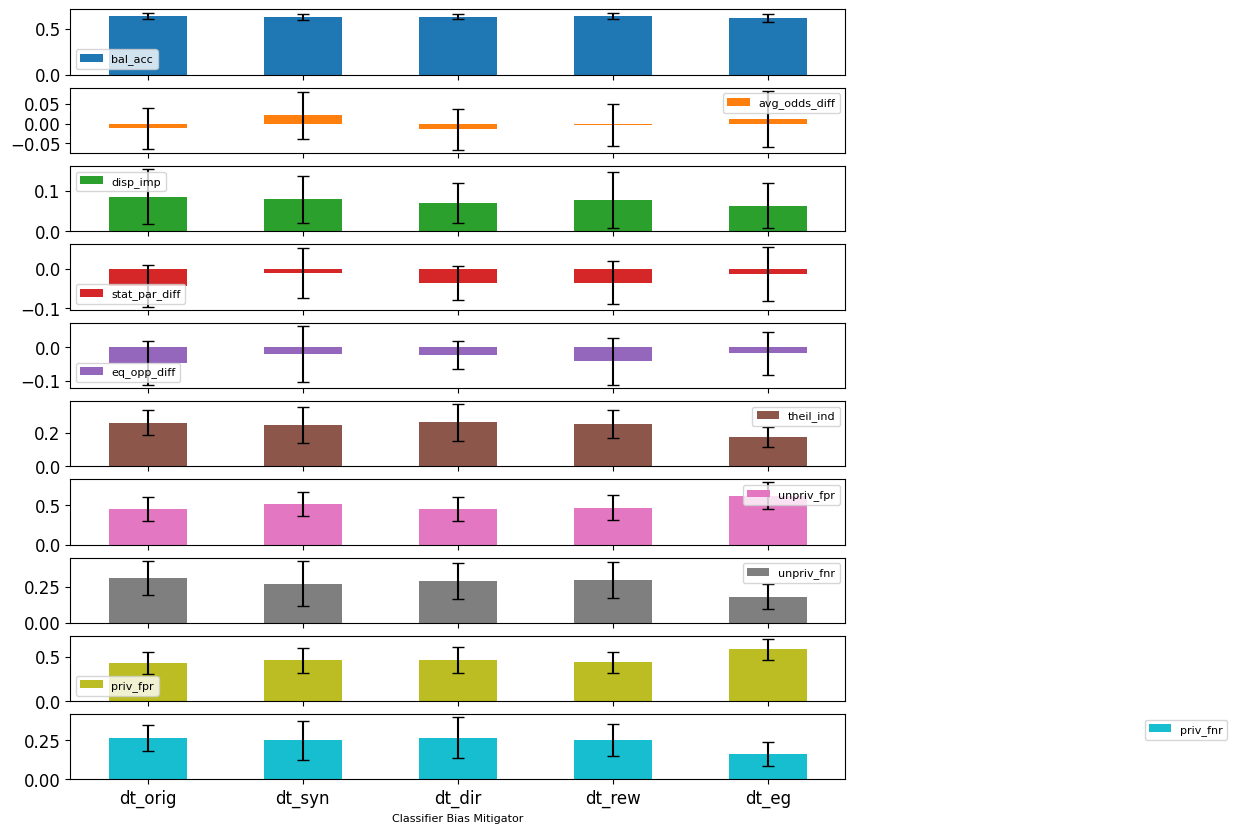

In [36]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean]
#         pr_orig_metrics_mean,
#         cpp_metrics_mean,
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics]
#         pr_orig_error_metrics,
#         cpp_error_metrics,
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [37]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [38]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [39]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,
orig,0.581250,0.645844,0.578155,0.637257,0.568623
syn,0.585000,0.659299,0.591862,0.643123,0.571278
dir,0.583000,0.650461,0.584787,0.648378,0.559535
rew,0.580833,0.645150,0.575649,0.638658,0.569174
eg,0.599750,0.690881,0.607045,0.677046,0.576722


In [40]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [41]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [42]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.645844,0.578155,0.637257,0.568623
syn,0.659299,0.591862,0.643123,0.571278
dir,0.650461,0.584787,0.648378,0.559535
rew,0.645150,0.575649,0.638658,0.569174
eg,0.690881,0.607045,0.677046,0.576722


<Axes: xlabel='Classifier MIA Attacks'>

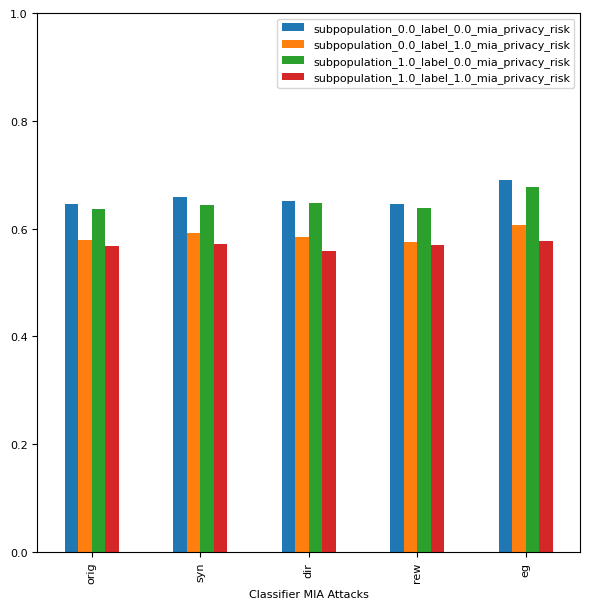

In [43]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [44]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.645844  0.659299  0.650461  0.64515   0.690881
subpopulation_0.0_label_1.0_mia_privacy_risk  0.578155  0.591862  0.584787  0.575649  0.607045
subpopulation_1.0_label_0.0_mia_privacy_risk  0.637257  0.643123  0.648378  0.638658  0.677046
subpopulation_1.0_label_1.0_mia_privacy_risk  0.568623  0.571278  0.559535  0.569174  0.576722


### Visualizing using novel technique

In [48]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [49]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [50]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.561667
1,orig,entire_dataset_mia_privacy_risk,0.558333
2,orig,entire_dataset_mia_privacy_risk,0.578333
3,orig,entire_dataset_mia_privacy_risk,0.595000
4,orig,entire_dataset_mia_privacy_risk,0.583333
...,...,...,...
200,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.600723
201,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.581441
202,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.586538
203,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558868


In [51]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.561667
1,orig,entire_dataset_mia_privacy_risk,0.558333
2,orig,entire_dataset_mia_privacy_risk,0.578333
3,orig,entire_dataset_mia_privacy_risk,0.595000
4,orig,entire_dataset_mia_privacy_risk,0.583333
...,...,...,...
200,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.600723
201,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.581441
202,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.586538
203,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.558868


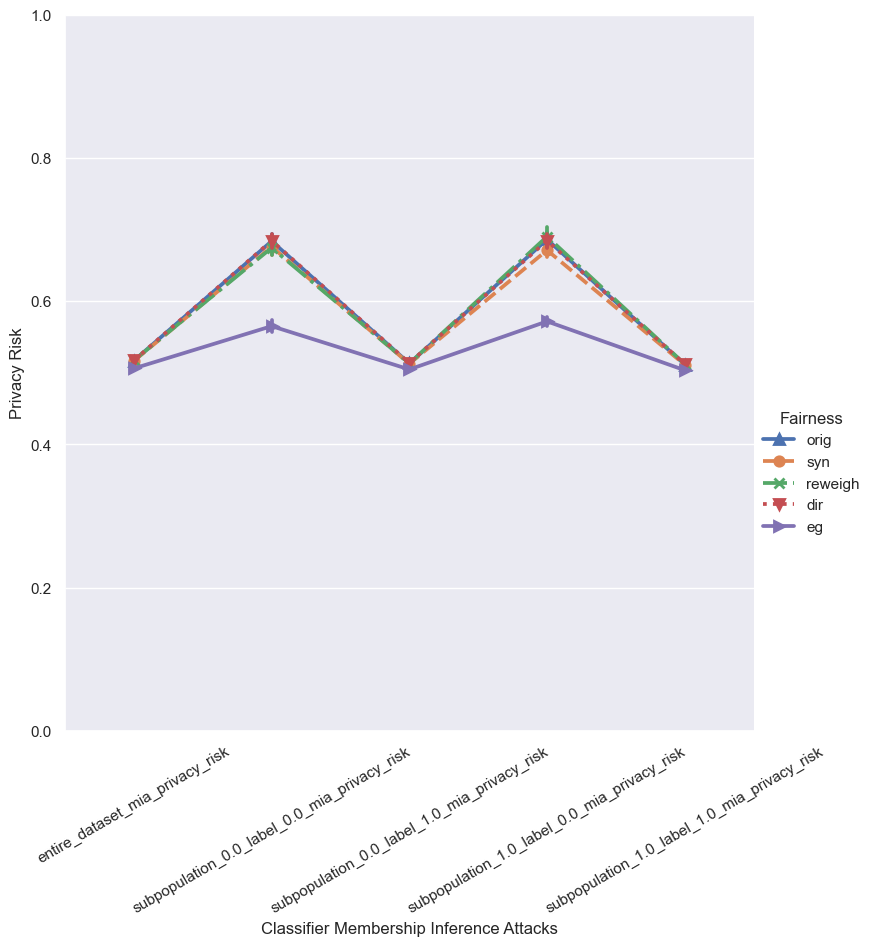

In [99]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [100]:
from sklearn.metrics import RocCurveDisplay, auc

In [101]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

In [ ]:
# train_test_egr